In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.patches import Rectangle
import stumpy
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import table 

from helper_functions import read_in_file, plot_time_window

np.set_printoptions(suppress=True)

data_directory = './data/Feb2022/' # The root directory for where all the data files are stored
overall_filename = 'february_data.csv' # Filename where the concatenated individual files will be stored

Start of Matrix Profile Analysis

In [4]:
class MatrixProfiler():
    '''This class performs and plots the result from performing a matrix profile on a given time window of data.'''

    def __init__(self, m=3, t1=None, t2=None, normalize=True, fontsize=14, save_fig=False, fname=None, figsize=(18,10)):
        '''Constructor for the MatrixProfiler.
        
        Args:
            m: int
                Window size for the matrix profile algorithm.
            t1: Datetime
                Starting time window for analysis (inclusive).
            t2: Datetime
                Ending time window for analysis (exclusive).
            normalize: bool
                If true, normalize the data according to min-max normalization.
            fontsize: int
                Fontize for plot labels, title, etc
            savefig: bool
                If true, save the output figure to a file.
            fname: str
                The filename to store the saved figure. Ex: "test-matrix-profile.png"
            figsize: tup
                The dimensions of the output figure. (w x h)
        '''
        self.m = m
        self.t1, self.t2 = t1, t2
        self.fontsize = fontsize
        self.save_fig = save_fig
        self.fname = fname
        self.figsize = figsize
        self.normalize = normalize

    def fit(self, df):
        self.n_dim = len(df.columns)

        if self.t1 is not None \
            and self.t2 is not None \
            and self.t1 < self.t2:
            self.df = df[(df.index >= self.t1) & (df.index < self.t2)]

        if self.normalize:
            self.df.iloc[:,:] = MinMaxScaler().fit_transform(self.df.iloc[:,:])

        if self.n_dim > 1: # If you have more than one dimension
            self.do_matrix_profile_nd()
        else:
            self.do_matrix_profile_1d()

    def do_matrix_profile_1d(self):
        '''Performs an 1-dimensional matrix profile to find motifs and discords.
        
        This function will display a PyPlot figure for the matrix profile.
        
        Args:
            df: Pandas DataFrame
                A Pandas DataFrame with exactly one column. Additionally, that column of the DataFrame needs to be of type
                float. This function will not work with non-continuos datatypes present in the DataFrame.
            m: int
                The window size for the matrix profile.
                
        Returns:
            None. Only the output is displayed.
        '''
        
        self.mp = stumpy.stump(self.df.iloc[:, 0], self.m)
        self.discord_idx = np.argsort(self.mp[:, 0])[-1]

    def do_matrix_profile_nd(self, df):
        '''Performs an n-dimensional matrix profile to find motifs, where n > 1. This function will display PyPlot figures for each dimension of the matrix profile.
        
        Args:
            df: Pandas DataFrame
                A Pandas DataFrame with more than one column and whose number of columns is greater than 1. Additionally,
                each column of the DataFrame needs to be of type float. This function will not work with non-continuos
                datatypes present in the DataFrame.
            m: int
                The window size for the matrix profile.
                
        Returns:
            None. Only the output is displayed.
        '''

        self.mp, self.indices = stumpy.mstump(df, self.m)
        self.discord_idx = np.argsort(self.mp, axis=1)[:, -1]

    def display(self):
        if self.n_dim == 1:
            nrows = 2
            figsize = self.figsize
            self.fig, self.axs = plt.subplots(nrows, sharex=True, sharey=False, gridspec_kw={'hspace': 0}, figsize=figsize)
            self.display_1d()
        else:
            nrows = self.mp.shape[0] * 2
            figsize = (18,5*self.df.shape[1])
            self.fig, self.axs = plt.subplots(nrows, sharex=True, sharey=False, gridspec_kw={'hspace': 0}, figsize=figsize)
            self.display_2d()

        if self.save_fig:
            plt.tight_layout()
            plt.savefig(self.fname, dpi=300)

        plt.show()

    def display_1d(self):
        plt.suptitle('Discord (Anomaly/Novelty) Discovery - Window Size {}'.format(self.m), fontsize=self.fontsize)
        self.axs[0].plot(self.df.iloc[:, 0].values)
        self.axs[0].set_ylabel(list(self.df.columns)[0], fontsize=self.fontsize)
        self.axs[1].set_xlabel('Time', fontsize =self.fontsize)
        self.axs[1].set_ylabel('Matrix Profile', fontsize=self.fontsize)
        self.axs[1].plot(self.mp[:, 0])

        rect = Rectangle((self.discord_idx, 0), self.m, max(self.df.iloc[:, 0]), facecolor='red', alpha=.35)
        self.axs[0].add_patch(rect)
        self.axs[1].axvline(x=self.discord_idx, linestyle="dashed", color='red', alpha=0.5)

    def display_2d(self):
        for k, dim_name in enumerate(self.df.columns):
            self.axs[k].set_ylabel(dim_name, fontsize=self.fontsize)
            self.axs[k].plot(np.arange(self.df.shape[0]), self.df[dim_name])
            self.axs[k].set_xlabel('Time', fontsize =self.fontsize)

            self.axs[k + self.mp.shape[0]].set_ylabel(dim_name.replace('T', 'P'), fontsize=self.fontsize)
            self.axs[k + self.mp.shape[0]].plot(self.mp[k], c='orange')
            self.axs[k + self.mp.shape[0]].set_xlabel('Time', fontsize =self.fontsize)

            self.axs[k].axvline(x=self.discord_idx[1], linestyle="dashed", c='black')
            self.axs[k + self.mp.shape[0]].axvline(x=self.discord_idx[1], linestyle="dashed", c='black')


In [35]:
# Read in the data from february
src_file = 'february_data_by_second.csv'
df_overall = read_in_file(src_file, keep_columns=['time', 'Continuous Bond Vibration', 'Continuous Bond FFT Band 3'])
# df_overall = df_overall.fillna(method='ffill') # Imputes NaNs from the last valid observation

                     Continuous Bond FFT Band 3  Continuous Bond Vibration
time                                                                      
2022-02-14 09:00:00                    0.000750                   0.043920
2022-02-14 09:00:01                    0.000758                   0.043692
2022-02-14 09:00:02                    0.000708                   0.043932
2022-02-14 09:00:03                    0.000729                   0.044033
2022-02-14 09:00:04                    0.000728                   0.043980


<Figure size 1296x288 with 0 Axes>

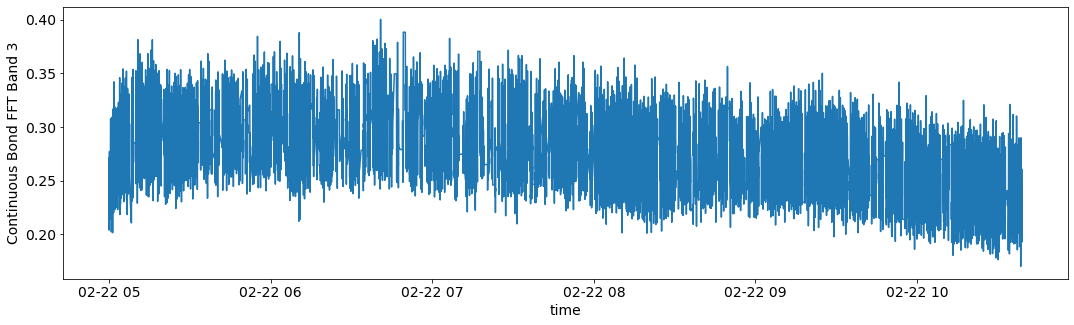

C:\Users\camer\AppData\Local\Temp\ipykernel_8224\3076719359.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df.iloc[:,:] = MinMaxScaler().fit_transform(self.df.iloc[:,:])


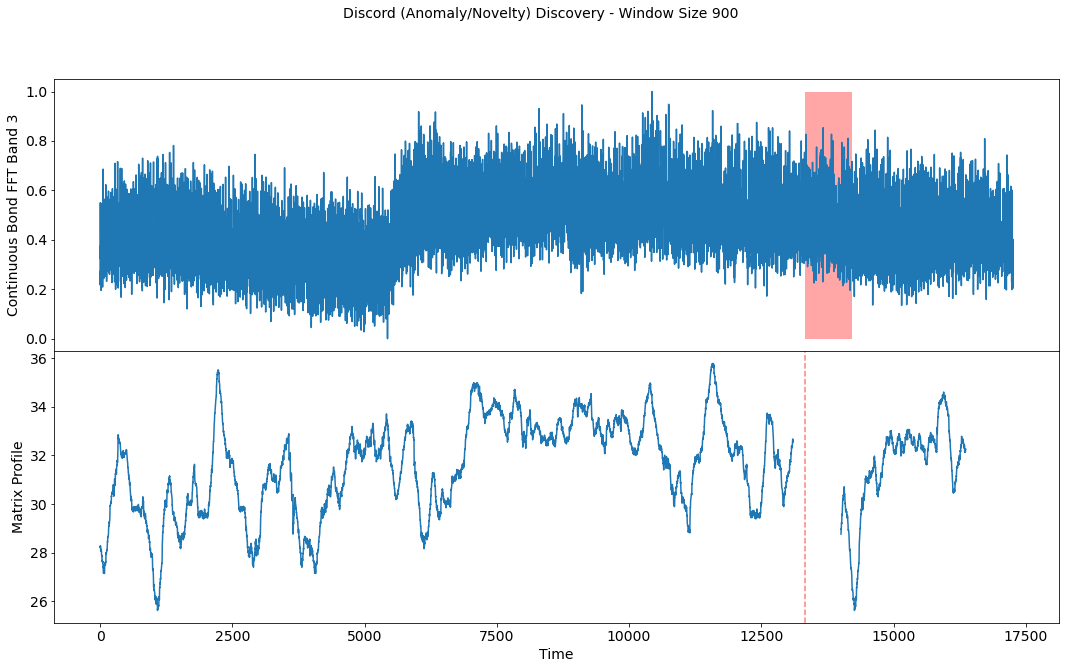

In [62]:
# Set the parameters for later analysis

t1 = datetime(year=2022, 
              month=2, 
              day=22, 
              hour=5, 
              minute=0, 
              second=0)
t2 = datetime(year=2022,
              month=2, 
              day=22, 
              hour=10, 
              minute=39, 
              second=0)

cols = ['Continuous Bond FFT Band 3']

print(df_overall.head())

# Plot the time window for some quick EDA
figure(figsize=(18,4))
plot_time_window(df_overall, t1, t2, cols[0])

matrix_profiler = MatrixProfiler(m=60*15, t1=t1, t2=t2)
matrix_profiler.fit(df_overall[cols])
matrix_profiler.display()

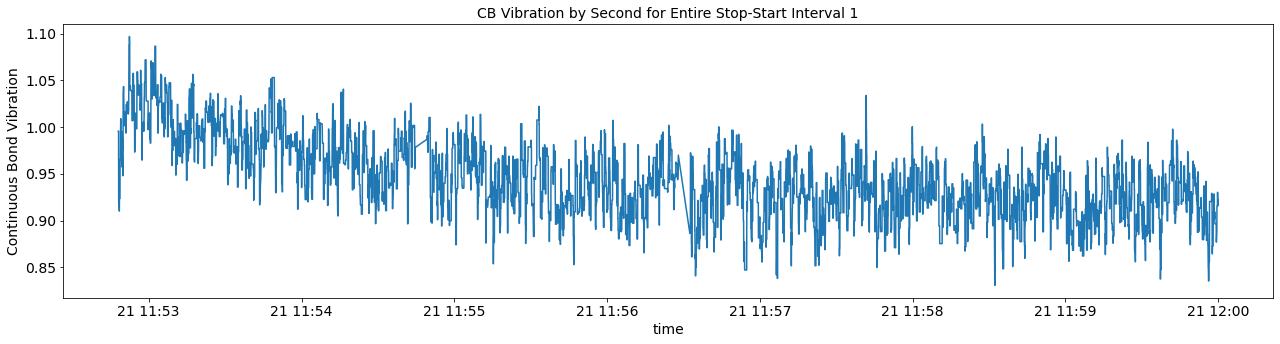

C:\Users\camer\anaconda3\envs\general\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\camer\anaconda3\envs\general\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


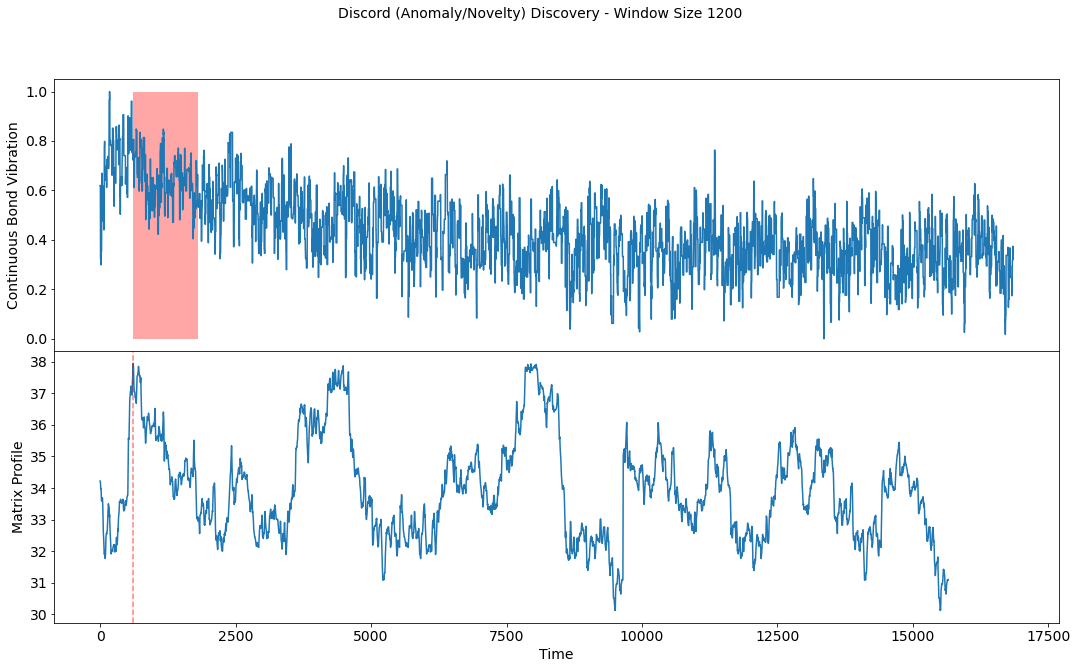

In [49]:
# Set the parameters for later analysis

t1 = datetime(year=2022, 
              month=2, 
              day=21, 
              hour=11, 
              minute=52, 
              second=48)
t2 = datetime(year=2022,
              month=2, 
              day=21, 
              hour=12, 
              minute=0, 
              second=0)

cols = ['Continuous Bond Vibration']
df = df_overall[cols]

# Plot the time window for some quick EDA
plot_time_window(df, t1, t2, cols[0], fontsize=14,
                 title="CB Vibration by Second for Entire Stop-Start Interval 1",
                 save_fig=True, fname="figs/cb-vibr_start-stop-interv_ex-1.png")

matrix_profiler = MatrixProfiler(m=1200, t1=t1, t2=t2)
matrix_profiler.fit(df)
matrix_profiler.display()